# Assignment 1

#### imports

In [ ]:
!pip install tqdm emoji gensim umap-learn rapidfuzz wordcloud nltk --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 42.0 MB/s eta 0:00:00


In [ ]:
import json
import re
from typing import List, Callable, Dict
from collections import OrderedDict
import numpy as np
import pandas as pd
from tqdm import tqdm
import emoji
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet
import gensim
import gensim.downloader as gloader
import umap
import matplotlib.pyplot as plt
from rapidfuzz import process, fuzz
from collections import Counter

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
np.random.seed(42)

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Task 1

> **TODO: Aggiungere data inspection (plots, distribution (lab 1))**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/My Drive/Assignment_NLP/A1/data" /content/

In [ ]:
def dataset_from_json(name):
    with open(name, 'r', encoding='utf-8') as f:
        data = json.load(f)
        df = pd.DataFrame.from_dict(data, orient='index')
        # take only the columns relevant for our task
        df = df[['id_EXIST', 'lang', 'tweet', 'labels_task2']]
        # rename last column into 'label' column
        df = df.rename(columns={'labels_task2': 'label'})
        # focus only on 'en' language
        df = df[df['lang'] == 'en']

        def most_frequent_or_drop(arr):
            if not isinstance(arr, list):
                return arr
            c = Counter(arr)
            most_common = c.most_common()
            if len(most_common) == 0:
                return None
            max_count = most_common[0][1]
            candidates = [val for val,
                          count in most_common if count == max_count]
            if len(candidates) > 1:
                return None
            return candidates[0]

        # the final label is the most present one
        df['label'] = df['label'].apply(most_frequent_or_drop)

        def map_label(label):
            mapping = {
                '-': 0,
                'DIRECT': 1,
                'JUDGEMENTAL': 2,
                'REPORTED': 3
            }
            return mapping.get(label, None)

        df = df.dropna(subset=['label'])
        df['label'] = df['label'].apply(map_label)

    return df

# no preprocessing
train_df_np = dataset_from_json('data/training.json')
val_df_np = dataset_from_json('data/validation.json')
test_df_np = dataset_from_json('data/test.json')

In [ ]:
train_df_np.head()
# test_df.head()

,id_EXIST,lang,tweet,label
200001,200001,en,FFS! How about laying the blame on the bastard...,0
200002,200002,en,Writing a uni essay in my local pub with a cof...,3
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,3
200004,200004,en,@GMB this is unacceptable. Use her title as yo...,0
200005,200005,en,‘Making yourself a harder target’ basically bo...,0


### Visualize the classes

`WordCloud` is a library to visualize words as a cloud of words. The most frequent words appear bigger than all the other words.

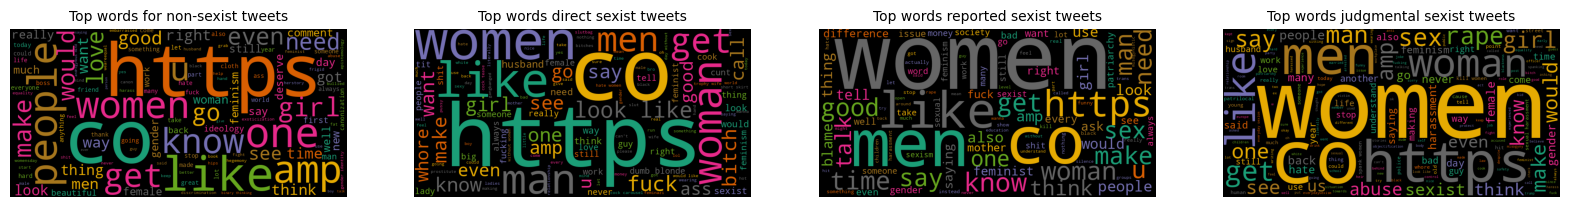

In [ ]:
n_posts = 1000
stop = set(stopwords.words('english')) # to ignore non informative words

# Create single strings containing all sentences belonging to each label
q_NS = ' '.join(train_df_np[train_df_np['label'] == 0]['tweet'].str.lower().values[:n_posts]) # No sexist
q_DS = ' '.join(train_df_np[train_df_np['label'] == 1]['tweet'].str.lower().values[:n_posts]) # Direct
q_RS = ' '.join(train_df_np[train_df_np['label'] == 2]['tweet'].str.lower().values[:n_posts]) # Report
q_JS = ' '.join(train_df_np[train_df_np['label'] == 3]['tweet'].str.lower().values[:n_posts]) # Judgemental

wordcloud_NS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_NS)
wordcloud_DS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_DS)
wordcloud_RS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_RS)
wordcloud_JS = WordCloud(max_font_size=None, stopwords=stop,scale = 2,colormap = 'Dark2').generate(q_JS)

fig, ax = plt.subplots(1,4, figsize=(20, 5))
ax[0].imshow(wordcloud_NS)
ax[0].set_title('Top words for non-sexist tweets',fontsize = 10)
ax[0].axis("off")

ax[1].imshow(wordcloud_DS)
ax[1].set_title('Top words direct sexist tweets',fontsize = 10)
ax[1].axis("off")

ax[2].imshow(wordcloud_RS)
ax[2].set_title('Top words reported sexist tweets',fontsize = 10)
ax[2].axis("off")

ax[3].imshow(wordcloud_JS)
ax[3].set_title('Top words judgmental sexist tweets',fontsize = 10)
ax[3].axis("off")

plt.show()

## Task 2

Example of how lemmatizer works: suppose the word is *"running"* and NLTK’s `pos_tag` determines it’s a verb (in particular a VGB, i.e. gerundive verb), it enters the "V" case in `get_wordnet_pos`, and then `lemmatizer.lemmatize("running", wordnet.VERB)` returns *"run"*.

In [ ]:
stop_words = set(stopwords.words('english'))  # set di stopwords inglesi

def clean_text(text: str) -> str:
    """Remove emojis, URLs, mentions, hashtags, special characters, extra spaces, and stopwords."""
    text = text.lower()
    text = emoji.replace_emoji(text, replace='')  # remove emojis
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)  # remove mentions and hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove special characters
    text = re.sub(r'\s+', ' ', text)  # remove extra spaces
    text = re.sub(r'["\'`\’\‘\“\”]', ' ', text)  # remove extra quotes

    # rimuovi stopwords
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words).strip()

def lemmatize_text(text: str) -> str:
    """Lemmatize text using POS tagging for more accurate results."""
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(tag):
        if tag.startswith('J'):
            return wordnet.ADJ
        elif tag.startswith('V'):
            return wordnet.VERB
        elif tag.startswith('N'):
            return wordnet.NOUN
        elif tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN

    words = text.split()
    pos_tags = pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]
    return ' '.join(lemmatized_words)

def text_preprocessing(df, column='tweet', pipeline=None):
    """
    Apply a sequence of preprocessing functions to a dataframe column.

    Parameters:
    - df: pandas DataFrame
    - column: name of the text column
    - pipeline: list of functions to apply sequentially
    """
    df = df.copy()
    if pipeline is None:
        pipeline = [clean_text, lemmatize_text]

    for func in pipeline:
        df[column] = df[column].apply(func)

    return df

In [ ]:
pipeline = [clean_text, lemmatize_text]

train_df = text_preprocessing(train_df_np, pipeline=pipeline)
val_df = text_preprocessing(val_df_np, pipeline=pipeline)
test_df = text_preprocessing(test_df_np, pipeline=pipeline)

In [ ]:
train_df.head()
# test_df.head()

,id_EXIST,lang,tweet,label
200001,200001,en,ffs lay blame bastard murder novel idea know,0
200002,200002,en,write uni essay local pub coffee random old ma...,3
200003,200003,en,dont appreciate two ride team member look behi...,3
200004,200004,en,unacceptable use title men interview fact seni...,0
200005,200005,en,make hard target basically boil make sure targ...,0


### Data Inspection and Statistics
We can repeate also for the dataframe before preprocessing to see the differences, add other form of EDA (Exploratory Data Analysis) or remove some.

In [ ]:
ID_tweet = train_df['id_EXIST'].iloc[0]
tweet_np = train_df_np['tweet'].iloc[0]
tweet_p = train_df['tweet'].iloc[0]

rand_tweet = np.random.randint(0, high=len(train_df))

ID_rand_tweet = train_df['id_EXIST'].iloc[rand_tweet]
tweet_rand_np = train_df_np['tweet'].iloc[rand_tweet]
tweet_rand_p = train_df['tweet'].iloc[rand_tweet]

In [ ]:
print(f"The tweet {ID_tweet} before preprocessing: {tweet_np}")
print(f"The tweet {ID_tweet} after preprocessing: {tweet_p}\n")

print(f"The tweet {ID_rand_tweet} before preprocessing: {tweet_rand_np}")
print(f"The tweet {ID_rand_tweet} after preprocessing: {tweet_rand_p}")

The tweet 200001 before preprocessing: FFS! How about laying the blame on the bastard who murdered her? Novel idea, I know. https://t.co/GI5B45THvJ
The tweet 200001 after preprocessing: ffs lay blame bastard murder novel idea know

The tweet 201457 before preprocessing: @KenGardner11 This is who Dak is.  Only bailed out by his pro bowl receivers who pick balls off their back hips and make him look decent.  This was why he was picked so late in the draft… he’s a late thrower and a late thinker.
The tweet 201457 after preprocessing: dak bail pro bowl receiver pick ball back hip make look decent pick late draft he late thrower late thinker


> sto seguendo questo [tutorial](https://www.kaggle.com/code/micheldc55/tutorial-eda-for-nlp-how-to-build-a-vocabulary/notebook)

In [ ]:
import seaborn as sns

As we can see, the dataset is imbalanced towords neutral tweets

<Axes: xlabel='label', ylabel='count'>

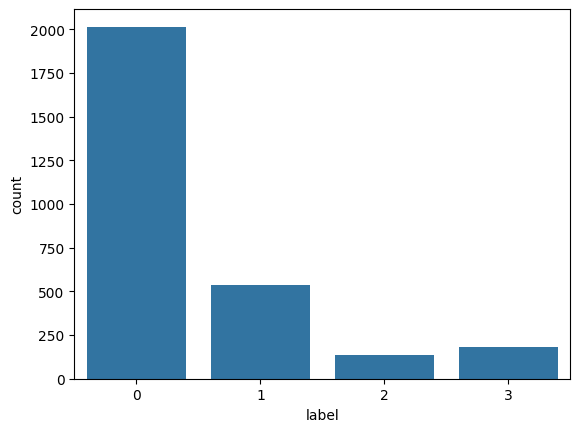

In [ ]:
sns.countplot(data=train_df, x='label')

Balance dataset

In [ ]:
from sklearn.utils import resample

def oversample_multiclass(df, target_col='label', random_state=101):
    """Balance a multi-class dataset by oversampling minority classes."""
    max_size = df[target_col].value_counts().max()

    oversampled_parts = [
        resample(df[df[target_col] == label],
                 replace=True,
                 n_samples=max_size,
                 random_state=random_state)
        for label in df[target_col].unique()
    ]

    df_oversampled = pd.concat(oversampled_parts)
    return df_oversampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

In [ ]:
train_df = oversample_multiclass(train_df)

<Axes: xlabel='label', ylabel='count'>

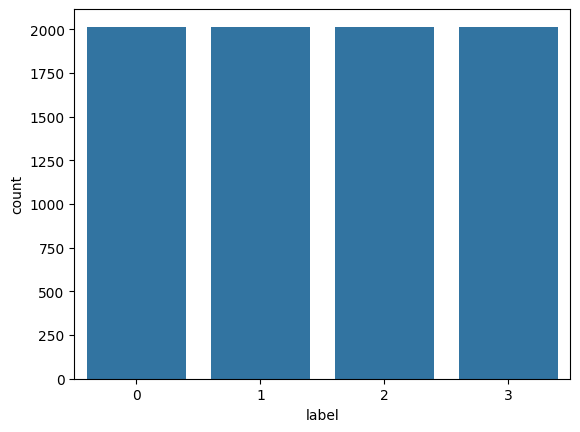

In [ ]:
sns.countplot(data=train_df, x='label')

In [ ]:
train_df_stats = train_df.copy()

In [ ]:
train_df_stats['string_length'] = train_df_stats['tweet'].map(lambda x: len(x))
train_df_stats.head()

,id_EXIST,lang,tweet,label,string_length
0,201087,en,post definitely fake lmfao woman cant force la...,1,110
1,201753,en,youd know good whose metanarrative found convi...,0,51
2,201234,en,yes want beautiful black wife love get gangban...,1,69
3,201045,en,cw weird fashy shitmy grandma lent american fa...,2,185
4,200139,en,tw pedophiliajust story chalk event last weeks...,3,118


In [ ]:
train_df_stats['word_count'] = train_df_stats['tweet'].map(lambda x: len(x.split()))
train_df_stats.head()

,id_EXIST,lang,tweet,label,string_length,word_count
0,201087,en,post definitely fake lmfao woman cant force la...,1,110,18
1,201753,en,youd know good whose metanarrative found convi...,0,51,7
2,201234,en,yes want beautiful black wife love get gangban...,1,69,11
3,201045,en,cw weird fashy shitmy grandma lent american fa...,2,185,26
4,200139,en,tw pedophiliajust story chalk event last weeks...,3,118,20


In [ ]:
from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')
train_df_stats['sentence_length'] = train_df_stats['tweet'].map(lambda x: len(sent_tokenize(x)))
train_df_stats.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,id_EXIST,lang,tweet,label,string_length,word_count,sentence_length
0,201087,en,post definitely fake lmfao woman cant force la...,1,110,18,1
1,201753,en,youd know good whose metanarrative found convi...,0,51,7,1
2,201234,en,yes want beautiful black wife love get gangban...,1,69,11,1
3,201045,en,cw weird fashy shitmy grandma lent american fa...,2,185,26,1
4,200139,en,tw pedophiliajust story chalk event last weeks...,3,118,20,1


As we can see, there the tweets are balanced wrt to words count, strings and sentences length.

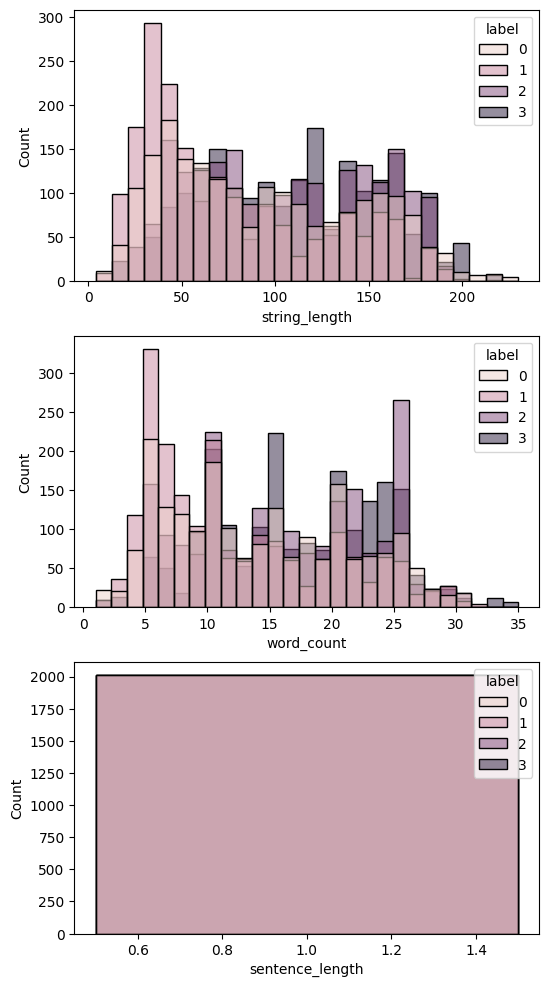

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 12))

for idx, column in enumerate(['string_length', 'word_count', 'sentence_length']):
    sns.histplot(data=train_df_stats, x=column, hue='label', ax=ax[idx])

## Task3 - Samuele

### Prova 1 - Copy of lab2

In [ ]:
def build_vocabulary(
    df: pd.DataFrame
) -> (Dict[int, str], Dict[str, int], List[str]):
    """
    Given a dataset, builds the corresponding word vocabulary.

    :param df: dataset from which we want to build
    the word vocabulary (pandas.DataFrame)
    :return:
      - word vocabulary: vocabulary index to word
      - inverse word vocabulary: word to vocabulary index
      - word listing: set of unique terms that build up the vocabulary
    """
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()

    curr_idx = 0
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    word_listing = list(idx_to_word.values())
    return idx_to_word, word_to_idx, word_listing

In [ ]:
idx_to_word, word_to_idx, word_listing = build_vocabulary(train_df)
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')

some_words = [(idx_to_word[idx], idx) for idx in np.arange(10) + 1]
print(f'[Debug] Some words: {some_words}')

100%|██████████| 2873/2873 [00:00<00:00, 48479.02it/s]

[Debug] Index -> Word vocabulary size: 9519
[Debug] Word -> Index vocabulary size: 9519
[Debug] Some words: [('how', np.int64(1)), ('about', np.int64(2)), ('lay', np.int64(3)), ('the', np.int64(4)), ('blame', np.int64(5)), ('on', np.int64(6)), ('bastard', np.int64(7)), ('who', np.int64(8)), ('murder', np.int64(9)), ('her', np.int64(10))]


In [ ]:
def evaluate_vocabulary(
    idx_to_word: Dict[int, str],
    word_to_idx: Dict[str, int],
    word_listing: List[str],
    df: pd.DataFrame,
    check_default_size: bool = False
):
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

In [ ]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, train_df)
print("\nEvaluation completed!")

Vocabulary evaluation...


100%|██████████| 2873/2873 [00:00<00:00, 21590.14it/s]



Evaluation completed!


### Prova - 2

Create Vocabulary

In [ ]:
import numpy as np
import pandas as pd
from collections import OrderedDict
from tqdm import tqdm

def build_vocabulary(
    df: pd.DataFrame,
    column_name: str = "tweet",
    add_special_tokens: bool = True
):
    """
    Builds a complete vocabulary from a DataFrame column.
    Returns mappings (idx_to_word, word_to_idx), word listing, and frequency DataFrame.

    :param df: DataFrame containing the text column.
    :param column_name: Name of the column to process.
    :param add_special_tokens: Whether to include <PAD> and <UNK> tokens.
    :return:
        - idx_to_word (OrderedDict[int, str])
        - word_to_idx (OrderedDict[str, int])
        - word_listing (List[str])
        - vocab_df (pd.DataFrame with 'vocabulary' and 'counts')
    """

    # Crea una lista di token da tutte le frasi
    text_array = df[column_name].values
    list_of_token_lists = [t.split() for t in text_array]
    repeated_vocab = np.concatenate(list_of_token_lists)
    repeated_vocab = repeated_vocab[repeated_vocab != ""]  # rimuove vuoti

    # Conta la frequenza di ogni parola
    token_array, counts_array = np.unique(repeated_vocab, return_counts=True)

    # Ordina per frequenza decrescente
    sorted_indices = np.argsort(-counts_array)
    token_array = token_array[sorted_indices].tolist()
    counts_array = counts_array[sorted_indices]

    # Crea mapping ordinati
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 0

    if add_special_tokens:
        for tok in ["<PAD>", "<UNK>"]:
            word_to_idx[tok] = curr_idx
            idx_to_word[curr_idx] = tok
            curr_idx += 1

    for token in tqdm(token_array, desc="Building vocabulary"):
        word_to_idx[token] = curr_idx
        idx_to_word[curr_idx] = token
        curr_idx += 1

    # Costruisci lista parole e DataFrame
    word_listing = list(idx_to_word.values())
    vocab_df = pd.DataFrame({"vocabulary": token_array, "counts": counts_array})

    return idx_to_word, word_to_idx, word_listing, vocab_df

In [ ]:
idx_to_word, word_to_idx, word_listing, vocab_df = build_vocabulary(train_df)

print("Size:", len(word_to_idx))
print("Most common words:\n", vocab_df.head(10))
print("Example mapping:", list(word_to_idx.items())[:10])

Building vocabulary: 100%|██████████| 7573/7573 [00:00<00:00, 1275948.59it/s]

Size: 7575
Most common words:
   vocabulary  counts
0      woman    4025
1       like    1713
2        men    1303
3       dont    1089
4        get    1082
5        say    1062
6       make     786
7         go     683
8       know     644
9        man     612
Example mapping: [('<PAD>', 0), ('<UNK>', 1), ('woman', 2), ('like', 3), ('men', 4), ('dont', 5), ('get', 6), ('say', 7), ('make', 8), ('go', 9)]


In [ ]:
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')

[Debug] Index -> Word vocabulary size: 7575
[Debug] Word -> Index vocabulary size: 7575


In [ ]:
def evaluate_vocabulary(
    idx_to_word: Dict[int, str],
    word_to_idx: Dict[str, int],
    word_listing: List[str],
    df: pd.DataFrame,
    check_default_size: bool = False
):
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    _, _, first_word_listing, _ = build_vocabulary(df)
    _, _, second_word_listing, _ = build_vocabulary(df)
    assert first_word_listing == second_word_listing

In [ ]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, train_df)
print("")
print("Evaluation completed!")

Vocabulary evaluation...


Building vocabulary: 100%|██████████| 7573/7573 [00:00<00:00, 1143434.40it/s]


Evaluation completed!


save vocabulary

In [ ]:
from pathlib import Path
import simplejson as sj

In [ ]:
vocab_path = Path.cwd().joinpath('data', 'vocab.json')

print(f"Saving vocabulary to {vocab_path}")
with vocab_path.open(mode='w') as f:
    sj.dump(word_to_idx, f, indent=4)
print("Saving completed!")

Saving vocabulary to /content/data/vocab.json
Saving completed!


Handling OOV

In [ ]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

**SAREBBE INTERESSANTE VARIARE EMBEDDING DIM E VEDERE COSA CAMBIA**

In [ ]:
embedding_dimension = 50

In [ ]:
embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=embedding_dimension)

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):
    """
    Checks differences between pre-trained embedding model vocabulary
    and dataset specific vocabulary in order to highlight out-of-vocabulary terms.

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_listing: dataset specific vocabulary (list)

    :return
        - list of OOV terms
    """
    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)
print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")
print(oov_terms[:3])

Total OOV terms: 1242 (16.40%)
['ubulge', 'impassion', 'congratsyou']


Create embeddings

In [ ]:
import torch

def build_embedding_matrix(
    embedding_model,
    embedding_dimension: int,
    word_to_idx: Dict[str, int],
    vocab_size: int,
    oov_terms: List[str] = None,
    unk_token: str = "<UNK>",
    random_seed: int = 42
) -> torch.Tensor:
    """
    Builds an embedding matrix for a dataset, handling OOV and <UNK> tokens.

    :param embedding_model: pre-trained word embeddings (GloVe)
    :param embedding_dimension: dimensionality of embeddings
    :param word_to_idx: dictionary mapping words to indices
    :param vocab_size: total vocabulary size
    :param oov_terms: list of OOV terms from training set
    :param unk_token: token used for unseen words in val/test
    :param random_seed: for reproducibility of random embeddings
    :return: embedding matrix (torch.Tensor) of shape [vocab_size, embedding_dimension]
    """
    np.random.seed(random_seed)
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    # Precompute a random vector for <UNK>
    unk_vector = np.random.uniform(-0.05, 0.05, embedding_dimension).astype(np.float32)

    for word, idx in tqdm(word_to_idx.items(), desc="Building embedding matrix"):
        if word == unk_token:
            embedding_matrix[idx] = unk_vector
        else:
            try:
                # se la parola esiste in GloVe → usa embedding pre-addestrato
                embedding_vector = embedding_model[word]
            except KeyError:
                # parola OOV nel training set → embedding random
                embedding_vector = np.random.uniform(-0.05, 0.05, embedding_dimension).astype(np.float32)
            embedding_matrix[idx] = embedding_vector

    # Converti in torch.Tensor pronta per PyTorch
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)
    return embedding_matrix

In [ ]:
vocab_size = len(word_to_idx)

embedding_matrix = build_embedding_matrix(
    embedding_model=embedding_model,
    embedding_dimension=embedding_dimension,
    word_to_idx=word_to_idx,
    vocab_size=vocab_size,
    oov_terms=oov_terms,
    unk_token="<UNK>"
)

print()
print(embedding_matrix.shape)  # [vocab_size, embedding_dim]

Building embedding matrix: 100%|██████████| 7575/7575 [00:00<00:00, 177279.49it/s]


torch.Size([7575, 50])


Co-occurrence matrix

In [ ]:
def co_occurrence_count(df: pd.DataFrame,
                        idx_to_word: Dict[int, str],
                        word_to_idx: Dict[str, int],
                        window_size: int = 4) -> np.ndarray:
    """
    Builds word-word co-occurrence matrix based on word counts.

    :return
      - co_occurrence symmetric matrix of size |V| x |V|
    """
    vocab_size = len(idx_to_word)
    co_occurrence_matrix = np.zeros((vocab_size, vocab_size),
                                    dtype=np.float32)
    for sentence in tqdm(df.tweet.values):
        tokens = sentence.split()
        for pos, token in enumerate(tokens):
            start = max(0, pos - window_size)
            end = min(pos + window_size + 1, len(tokens))

            first_word_index = word_to_idx[token]
            for pos2 in range(start, end):
                if pos2 != pos:
                    second_token = tokens[pos2]
                    second_word_index = word_to_idx[second_token]
                    co_occurrence_matrix[first_word_index,
                                         second_word_index] += 1
    return co_occurrence_matrix

In [ ]:
# Clean RAM before re-running this code snippet
# to avoid possible session crash
if 'co_occurrence_matrix' in globals():
    del co_occurrence_matrix
    gc.collect()
    time.sleep(10.)     # Give colab some time

print("Building co-occurrence count matrix.. (it may take a while..)")
co_occurrence_matrix = co_occurrence_count(train_df,
                                           idx_to_word,
                                           word_to_idx,
                                           window_size=4)
print("Building completed!")

Building co-occurrence count matrix.. (it may take a while..)


100%|██████████| 8056/8056 [00:02<00:00, 2911.56it/s]

Building completed!


>**TODO: Similarity**


Visualization

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import umap
import matplotlib.pyplot as plt

In [ ]:
def visualize_embeddings(embeddings: np.ndarray,
                         word_annotations: List[str] = None,
                         word_to_idx: Dict[str, int] = None):
    """
    Plots given reduce word embeddings (2D). Users can highlight specific words (word_annotations list).

    :param embeddings: word embedding matrix of shape (words, 2) retrieved via a dimensionality reduction technique.
    :param word_annotations: list of words to be annotated.
    :param word_to_idx: vocabulary map (word -> index) (dict)
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    if word_annotations:
        print(f"Annotating words: {word_annotations}")

        word_indexes = []
        for word in word_annotations:
            word_index = word_to_idx[word]
            word_indexes.append(word_index)

        word_indexes = np.array(word_indexes)

        other_embeddings = embeddings[np.setdiff1d(np.arange(embeddings.shape[0]), word_indexes)]
        target_embeddings = embeddings[word_indexes]

        ax.scatter(other_embeddings[:, 0], other_embeddings[:, 1], alpha=0.1, c='blue')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1.0, c='red')
        ax.scatter(target_embeddings[:, 0], target_embeddings[:, 1], alpha=1, facecolors='none', edgecolors='r', s=1000)

        for word, word_index in zip(word_annotations, word_indexes):
            word_x, word_y = embeddings[word_index, 0], embeddings[word_index, 1]
            ax.annotate(word, xy=(word_x, word_y))
    else:
        ax.scatter(embeddings[:, 0], embeddings[:, 1], alpha=0.1, c='blue')

    # We avoid outliers ruining the visualization if they are quite far away
    axis_x_limit = (np.min(embeddings[:, 0]), np.max(embeddings[:, 0]))
    axis_y_limit = (np.min(embeddings[:, 1]), np.max(embeddings[:, 1]))
    plt.xlim(left=axis_x_limit[0] - 0.5, right=axis_x_limit[1] + 0.5)
    plt.ylim(bottom=axis_y_limit[0] - 0.5, top=axis_y_limit[1] + 0.5)
    ax.set_xlim(axis_x_limit[0], axis_x_limit[1])
    ax.set_ylim(axis_y_limit[0], axis_y_limit[1])

In [ ]:
def reduce_SVD(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies SVD dimensionality reduction.

    :param embeddings: word embedding matrix of shape (words, dim). In the case
                       of a word-word co-occurrence matrix the matrix shape would
                       be (words, words).

    :return
        - 2-dimensional word embedding matrix of shape (words, 2)
    """
    svd = TruncatedSVD(n_components=2, n_iter=10)
    reduced = svd.fit_transform(embeddings)

    return reduced

In [ ]:
def reduce_tSNE(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies t-SNE dimensionality reduction.
    """
    tsne = TSNE(n_components=2, n_iter=1000, metric='cosine')
    reduced = tsne.fit_transform(embeddings)

    return reduced

In [ ]:
def reduce_umap(embeddings: np.ndarray) -> np.ndarray:
    """
    Applies UMAP dimensionality reduction.
    """
    umap_emb = umap.UMAP(n_components=2, metric='cosine')
    reduced = umap_emb.fit_transform(embeddings)

    return reduced

In [ ]:
# Feel free to play with word_annotations argument!
# Check the saved dictionary!
def run_visualization(method_name: str,
                      words_list: List[str],
                      word_to_idx: Dict[str, int],
                      co_occurrence_matrix):
    method_name = method_name.lower().strip()
    method_map = {
        'svd': reduce_SVD,
        'tsne': reduce_tSNE,
        'umap': reduce_umap
    }

    if method_name not in method_map:
        raise RuntimeError(f'Invalid method name! Got {method_name}.')

    reduced = method_map[method_name](co_occurrence_matrix)
    visualize_embeddings(reduced, words_list, word_to_idx)

Annotating words: ['good', 'love', 'beautiful']


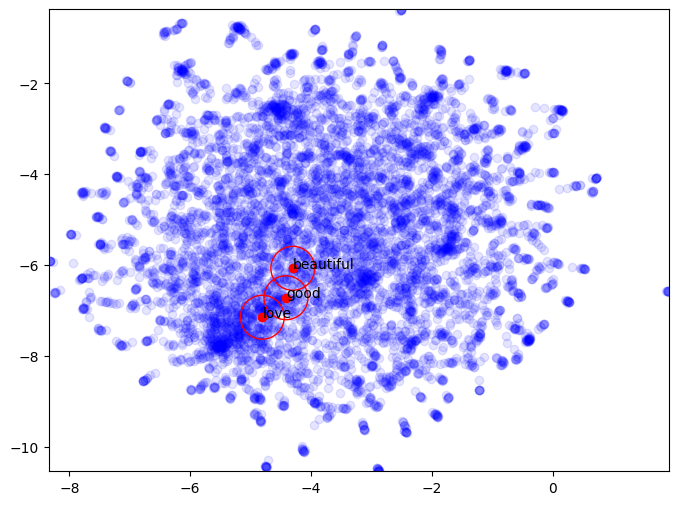

In [ ]:
run_visualization('umap', ['good', 'love', 'beautiful'],
                  word_to_idx, co_occurrence_matrix)

Annotating words: ['drive', 'woman', 'man']


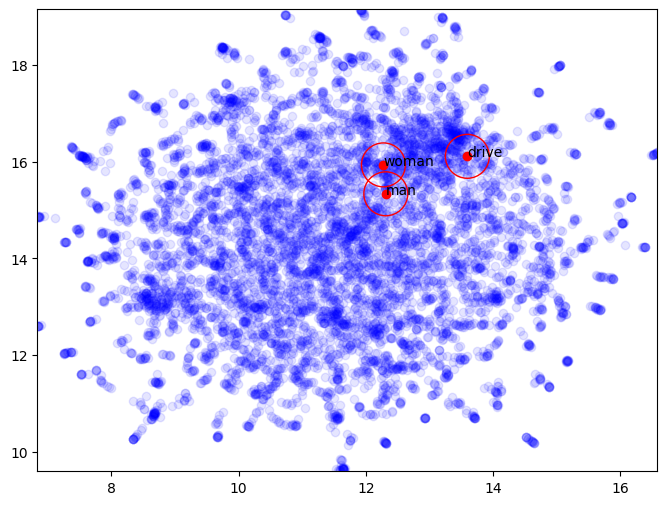

In [ ]:
run_visualization('umap', ['drive', 'woman', 'man'],
                  word_to_idx, co_occurrence_matrix)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Annotating words: ['drive', 'woman', 'man']


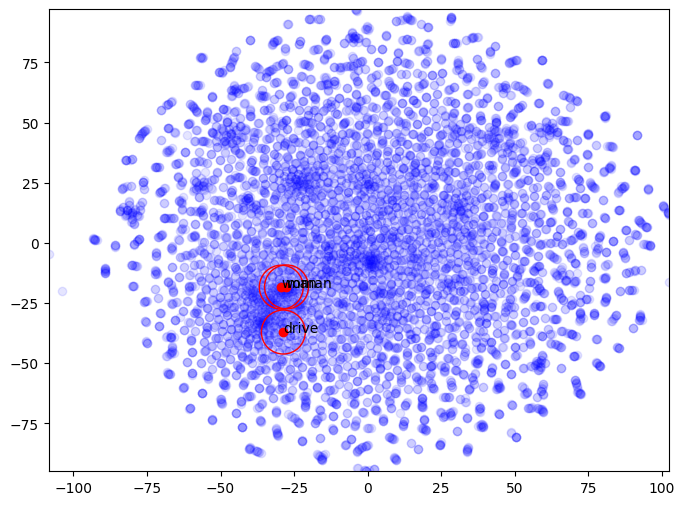

In [ ]:
run_visualization('tsne', ['drive', 'woman', 'man'],
                  word_to_idx, co_occurrence_matrix)

Annotating words: ['yearolds', 'needle', 'worldview']


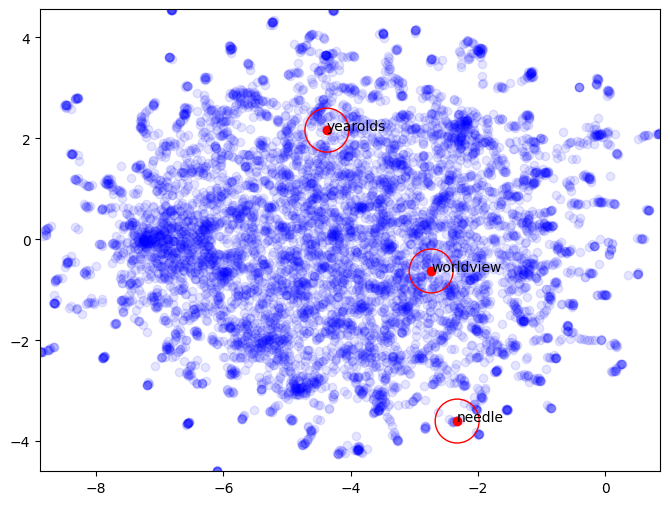

In [ ]:
rand_words = np.random.choice(list(word_to_idx.keys()), size=3, replace=False).tolist()
run_visualization('umap',rand_words, word_to_idx, co_occurrence_matrix)

## TASK 4

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.utils.rnn as rnn_utils

In [ ]:
device = "gpu" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
def text_to_indices(text, word_to_idx, unk_token="<UNK>"):
    return [word_to_idx.get(t, word_to_idx[unk_token]) for t in text.split()]

In [ ]:
# dataloader
class TweetDataset(Dataset):
    def __init__(self, df, word_to_idx, unk_token="<UNK>"):
        self.sequences = [text_to_indices(t, word_to_idx, unk_token) for t in df['tweet'].values]
        self.labels = df['label'].values.astype(int)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

# Collate function per padding
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = torch.tensor([len(seq) for seq in sequences])
    padded_seqs = rnn_utils.pad_sequence([torch.tensor(seq) for seq in sequences],
                                         batch_first=True, padding_value=word_to_idx["<PAD>"])
    labels = torch.tensor(labels)
    return padded_seqs, labels, lengths

batch_size = 32
train_loader = DataLoader(TweetDataset(train_df, word_to_idx), batch_size=batch_size,
                          shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(TweetDataset(val_df, word_to_idx), batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)

In [ ]:
import torch.nn as nn

class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim=128, num_classes=4, num_layers=1, dropout=0.3):
        super().__init__()
        vocab_size, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=word_to_idx["<PAD>"])
        self.bilstm = nn.LSTM(input_size=embedding_dim,
                              hidden_size=hidden_dim,
                              num_layers=num_layers,
                              bidirectional=True,
                              batch_first=True,
                              dropout=dropout if num_layers>1 else 0)
        self.fc = nn.Linear(hidden_dim*2, num_classes)

    def forward(self, x, lengths=None):
        embedded = self.embedding(x)
        if lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(),
                                                      batch_first=True,
                                                      enforce_sorted=False)
            packed_out, (h_n, c_n) = self.bilstm(packed)
        else:
            # se lengths non passato → usa sequenze intere (per summary)
            out, (h_n, c_n) = self.bilstm(embedded)

        # concatenazione hidden state
        h_forward = h_n[-2,:,:]
        h_backward = h_n[-1,:,:]
        h = torch.cat((h_forward, h_backward), dim=1)
        out = self.fc(h)
        return out

# Esempio di inizializzazione
model_baseline = BiLSTMClassifier(embedding_matrix, hidden_dim=128, num_layers=1)

In [ ]:
!pip install torchinfo
from torchinfo import summary

In [ ]:
max_string_length = train_df_stats['string_length'].max()
print(f"Lunghezza massima del tweet in caratteri: {max_string_length}")

Lunghezza massima del tweet in caratteri: 230


In [ ]:
summary(model_baseline, input_size=(batch_size, max_string_length), dtypes=[torch.long])

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Embedding: 1]